# Выбор локации для скважины

Добывающая компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

Этапы работы
1. [Загрузка и подготовка данных](#section1)
2. [Обучение и проверка модели](#section2)
3. [Подготовка к расчёту прибыли](#section3)
4. [Расчёт прибыли и рисков ](#section4)

<a id = 'section1'></a>
## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy.random import RandomState

Грузим геоданные, смотрим что по чем =)

In [3]:
df_geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_geo_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Признак Id не несет ценности, при построение модели лишь будет ее портить, удаляем.

In [4]:
df_geo_1 = df_geo_1.drop('id', axis = 1)
df_geo_1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [5]:
df_geo_1.isna().mean()

f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Отличненько, пропусков нет

In [6]:
df_geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB


Типы данных так же корректны

In [7]:
df_geo_1[df_geo_1['product'] == 0]

,f0,f1,f2,product
57263,-0.702064,0.375992,0.236572,0.0


Поищем артефакты, так как мы не знаем значения признаков f0, f1, f2, то посмотрим значение целевого признака product где он принимает 0 значение. Всего одно значение - дейстивтельно возможно пустая скважина или какая-то ошибка, но она не повлияет на модель существенно, оставляем как есть. Проведем аналогичную процедуру по подготовке с оставшимися геоданными.

In [8]:
df_geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_geo_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
df_geo_2 = df_geo_2.drop('id', axis = 1)
df_geo_2.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [10]:
df_geo_2.isna().mean()

f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

In [11]:
df_geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB


In [12]:
df_geo_2[df_geo_2['product']== 0]

,f0,f1,f2,product
11,16.320755,-0.562946,-0.001783,0.0
13,6.695604,-0.749449,-0.007630,0.0
62,21.418478,-5.134490,-0.002836,0.0
63,6.822701,3.104979,-0.000723,0.0
77,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...
99936,5.085749,-3.980305,0.005063,0.0
99948,8.277805,-9.178818,0.003275,0.0
99956,13.343983,-1.290200,0.005980,0.0
99961,13.854163,-11.528089,-0.005556,0.0


In [13]:
len(df_geo_2[df_geo_2['product']== 0])/len(df_geo_2)

0.08235

In [14]:
df_geo_3 = pd.read_csv('/datasets/geo_data_2.csv')
df_geo_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [15]:
df_geo_3 = df_geo_3.drop('id', axis = 1)
df_geo_3.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [16]:
df_geo_3.isna().mean()

f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

In [17]:
df_geo_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4)
memory usage: 3.1 MB


In [18]:
df_geo_3[df_geo_3['product']== 0]

,f0,f1,f2,product
68149,-0.865596,-1.615247,-4.126441,0.0


Во втором регионе много 0 значений по целевому признаку - 8,24% - значения утрачены или зачем-то в таблице оставлены значения объём запасов в скважине равные 0. Предлагаю заменить значения такого рода целевого признака на Nan, затем впоследствии заменим на медианные значения.

In [19]:
df_geo_1.duplicated().mean()

0.0

In [20]:
df_geo_2.duplicated().mean()

0.0

In [21]:
df_geo_3.duplicated().mean()

0.0

Отлично дубликатов так же нет

Все корректно, теперь предлагаю посмотреть на распределение целевого признака - объём запасов в скважине (тыс. баррелей)

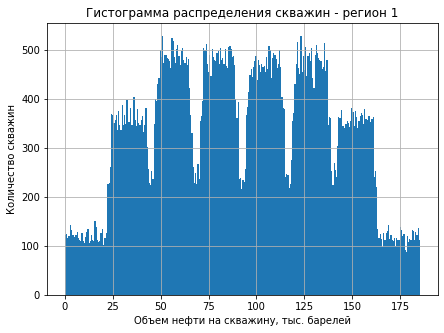

In [22]:
df_geo_1['product'].hist(bins = 300, figsize=[7,5])

plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")

plt.title("Гистограмма распределения скважин - регион 1")
plt.show()

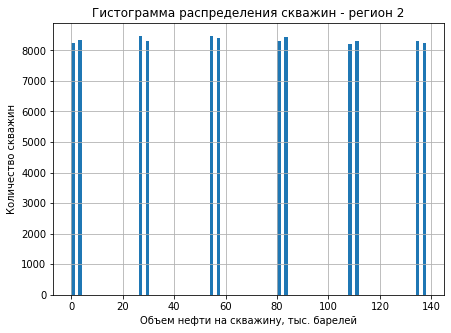

In [23]:
df_geo_2['product'].hist(bins = 100, figsize=[7,5])

plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")

plt.title("Гистограмма распределения скважин - регион 2")
plt.show()

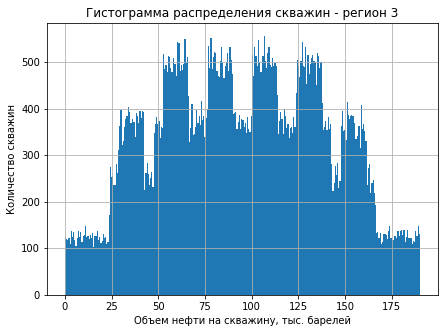

In [24]:
df_geo_3['product'].hist(bins = 300, figsize=[7,5])

plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")

plt.title("Гистограмма распределения скважин - регион 3")
plt.show()

В 1 и 3 регионах распределение целевого признака близко к нормальному, однако в регионе номер 2 распределение далеко от нормального. Так как я близко не знаком с предметной областью исследования, то задалбы заказчику вопрос о качестве данных или предположил, что во 2 регионе данные синтетически выведены.

### Вывод по разделу 1:
- данные загружены и подготовлены: тип данных корректен, удалены ненужные признаки, отсутствие дубликатов
- подготовлены 0 значения целевого значения
- проведен анализ распределения целевого признака: имеются соменния в качестве данных 2 региона

<a id = 'section2'></a>
## Обучение и проверка модели

Написал функцию для разделения выборки на фичи и таргеты. Разбил выборку на трейн и валид. 

In [25]:
def split_df(df, column):
    df = df.copy()
    
    x = df.drop(column, axis=1)
    y = df[column]
    
    return x, y

In [26]:
x_geo_1, y_geo_1 = split_df(df_geo_1, 'product')
x_geo_2, y_geo_2 = split_df(df_geo_2, 'product')
x_geo_3, y_geo_3 = split_df(df_geo_3, 'product')

In [27]:
x_geo_1_train, x_geo_1_valid, y_geo_1_train, y_geo_1_valid = train_test_split(
    x_geo_1, y_geo_1, test_size = 0.25, random_state = 42)

x_geo_2_train, x_geo_2_valid, y_geo_2_train, y_geo_2_valid = train_test_split(
    x_geo_2, y_geo_2, test_size = 0.25, random_state = 42)

x_geo_3_train, x_geo_3_valid, y_geo_3_train, y_geo_3_valid = train_test_split(
    x_geo_3, y_geo_3, test_size = 0.25, random_state = 42)

Напишем простой пайплан, который будет маштабировать наши данные, затем учить модельку. Подбор гиперпараметров модели произведем через GridsearchCV, в качесве целевой метрики используем r2.

In [28]:
pipe = Pipeline(steps =[
    ('tf1', StandardScaler()),
    ('model', LinearRegression()),
])

In [29]:
pipe_params = {'model__fit_intercept':[True, False],
               'model__normalize':[True, False],
               'model__copy_X':[True, False]
              }

In [30]:
gs_geo_1 = GridSearchCV(pipe, pipe_params, scoring = 'r2', cv = 5 )

In [31]:
gs_geo_1.fit(x_geo_1_train, y_geo_1_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [32]:
gs_geo_1.best_score_

0.27646862289690327

In [33]:
gs_geo_1.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [34]:
gs_geo_2 = GridSearchCV(pipe, pipe_params, scoring = 'r2', cv = 5 )

In [35]:
gs_geo_2.fit(x_geo_2_train, y_geo_2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [36]:
gs_geo_2.best_score_

0.9996243124448291

In [37]:
gs_geo_2.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [38]:
gs_geo_3 = GridSearchCV(pipe, pipe_params, scoring = 'r2', cv = 5 )

In [39]:
gs_geo_3.fit(x_geo_3_train, y_geo_3_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [40]:
gs_geo_3.best_score_

0.19948005045498196

In [41]:
gs_geo_3.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

Попробуем поискать оптимальные гиперпараметры когда целевая метрика MAE

In [42]:
gs_geo_1 = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_absolute_error', cv = 5 )

In [43]:
gs_geo_1.fit(x_geo_1_train, y_geo_1_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [44]:
gs_geo_1.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [45]:
gs_geo_1.best_score_

-31.03874324837525

In [46]:
gs_geo_2 = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_absolute_error', cv = 5 )

In [47]:
gs_geo_2.fit(x_geo_2_train, y_geo_2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [48]:
gs_geo_1.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [49]:
gs_geo_1.best_score_

-31.03874324837525

In [50]:
gs_geo_3 = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_absolute_error', cv = 5 )

In [51]:
gs_geo_3.fit(x_geo_3_train, y_geo_3_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [52]:
gs_geo_3.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [53]:
gs_geo_3.best_score_

-32.794528927009615

Попробуем поискать оптимальные гиперпараметры когда целевая метрика MSE

In [54]:
gs_geo_1 = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_squared_error', cv = 5 )

In [55]:
gs_geo_1.fit(x_geo_1_train, y_geo_1_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [56]:
gs_geo_1.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [57]:
gs_geo_1.best_score_

-1419.232642450053

In [58]:
gs_geo_2 = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_squared_error', cv = 5 )

In [59]:
gs_geo_2.fit(x_geo_2_train, y_geo_2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [60]:
gs_geo_2.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [61]:
gs_geo_2.best_score_

-0.7929182941132471

In [62]:
gs_geo_3 = GridSearchCV(pipe, pipe_params, scoring = 'neg_mean_squared_error', cv = 5 )

In [63]:
gs_geo_3.fit(x_geo_3_train, y_geo_3_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tf1',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'model__copy_X': [True, False],
                         'model__fit_intercept': [True, False],
                         'model__normalize': [True, False]},
             pre_dispatch='2*n_jobs'

In [64]:
gs_geo_3.best_params_

{'model__copy_X': True, 'model__fit_intercept': True, 'model__normalize': True}

In [65]:
gs_geo_3.best_score_

-1602.1656585116223

Получилось что для всех искомых целевых метрик оптимально подходят следующие гиперпараметры:
- copy_X: True,
- fit_intercept: True,
- normalize: True

Зафиксируем модель

In [66]:
linreg = Pipeline(steps =[
    ('tf1', StandardScaler()),
    ('model', LinearRegression(
        copy_X = True,
        fit_intercept = True,
        normalize = True)),
])

Сделаем предсказания на валидационной выборке, найдем RMSE и среднее кол-во запасов нефти в регионах

In [67]:
def oil_predicted(x_train, x_valid, y_train, y_valid):
    linreg.fit(x_train, y_train)    
    predicted = linreg.predict(x_valid)
    data = {'real' : y_valid,
            'predicted' : predicted
           }
    
    df = pd.DataFrame(data, columns = ['real', 'predicted'])
    rmse = mean_squared_error(y_valid, predicted)**0.5
    mean = df['predicted'].mean()
    
    return df, rmse, mean

In [68]:
geo_1_sum_up, geo_1_rmse, geo_1_mean = oil_predicted(x_geo_1_train, x_geo_1_valid, y_geo_1_train, y_geo_1_valid)
geo_2_sum_up, geo_2_rmse, geo_2_mean = oil_predicted(x_geo_2_train, x_geo_2_valid, y_geo_2_train, y_geo_2_valid)
geo_3_sum_up, geo_3_rmse, geo_3_mean = oil_predicted(x_geo_3_train, x_geo_3_valid, y_geo_3_train, y_geo_3_valid)

In [69]:
print('RMSE:', geo_1_rmse)
print('Средний запас сырья:', geo_1_mean)

RMSE: 37.75660035026169
Средний запас сырья: 92.39879990657768


In [70]:
print('RMSE:', geo_2_rmse)
print('Средний запас сырья:', geo_2_mean)

RMSE: 0.8902801001028836
Средний запас сырья: 68.71287803913762


In [71]:
print('RMSE:', geo_3_rmse)
print('Средний запас сырья:', geo_3_mean)

RMSE: 40.145872311342174
Средний запас сырья: 94.77102387765939


### Вывод по разделу 2:
- Подобраны гиперпараметры, дающие наиболее значимые целевые метрики
- Данные отмаштабированы
- Подсчитаны RMSE и средние запасы нефти по регионам

Исходя из полученных значений RMSE, наилучшей моделью хотелось бы назвать модель второго региона, где RMSE составило 0,89. Однако следует помнить, что в данных по региону номер 2 много артефактов в целевом признаке, а так же само распределение признаков похоже на синтетичиское, из чего можно предположить что моделька переобучилась. К тому же не считаю, что второй регион следует воспринимать как наиболее доходный, так как среднее значение запасов сырья здесь наименьшая 68.71

Наиболее прибыльным регионом может стать 3ий, где средний запас сырья 94,77. Затем следует рассматривать первый со средним запасом сырья 92,38.

<a id = 'section3'></a>
## Подготовка к расчёту прибыли

### Создадим константы для всех имеющихся переменных. Все денежные переменные представленны в тыс. руб

In [72]:
budget = 10000000
explored_points = 500
chosen_points = 200
price_per_barrel = 450

При условии, что отбирается при разработке лишь 200 лучших точек, то для безубыточного разработки доход одной точки должен составить:

In [73]:
averege_profit_per_point = budget / chosen_points
print(averege_profit_per_point, 'тыс. руб.')

50000.0 тыс. руб.


Тогда средний объем запас нефти для безубыточного разработки одной точки должен составить:

In [74]:
average_barrels_per_point = averege_profit_per_point / price_per_barrel
print(round(average_barrels_per_point, 2), 'тыс. барлей')

111.11 тыс. барлей


### Сравим полученные данные с фактическим средниим значениями по регионам

In [75]:
print('Средние фактическое значения запаса нефти в регионе 1:', df_geo_1['product'].mean())
print('Средние фактическое значения запаса нефти в регионе 2:', df_geo_2['product'].mean())
print('Средние фактическое значения запаса нефти в регионе 3:', df_geo_3['product'].mean())

Средние фактическое значения запаса нефти в регионе 1: 92.50000000000001
Средние фактическое значения запаса нефти в регионе 2: 68.82500000000002
Средние фактическое значения запаса нефти в регионе 3: 95.00000000000004


In [76]:
print('Средний запас сырья предсказанное в регионе 1:', geo_1_mean)
print('Средний запас сырья предсказанное в регионе 2:', geo_2_mean)
print('Средний запас сырья предсказанное в регионе 3:', geo_3_mean)

Средний запас сырья предсказанное в регионе 1: 92.39879990657768
Средний запас сырья предсказанное в регионе 2: 68.71287803913762
Средний запас сырья предсказанное в регионе 3: 94.77102387765939


In [77]:
print('RMSE в регионе 1:', geo_1_rmse)
print('RMSE в регионе 2:', geo_2_rmse)
print('RMSE в регионе 3:', geo_3_rmse)

RMSE в регионе 1: 37.75660035026169
RMSE в регионе 2: 0.8902801001028836
RMSE в регионе 3: 40.145872311342174


### Напишем функцию для расчета прибыли

In [78]:
def oil_profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    revenue = selected.sum() * price_per_barrel
    return revenue - budget

### Посмотрим какое значение прибыли сможем получить если 100% самые жирные месторождения в кажом регионе

In [79]:
profit_geo_1 = oil_profit(geo_1_sum_up['real'], geo_1_sum_up['predicted'], chosen_points)
profit_geo_2 = oil_profit(geo_2_sum_up['real'], geo_2_sum_up['predicted'], chosen_points)
profit_geo_3 = oil_profit(geo_3_sum_up['real'], geo_3_sum_up['predicted'], chosen_points)

print('Максимальная возможная прибыль в регионе 1, тыс. руб.:', round(profit_geo_1, 2))
print('Максимальная возможная прибыль в регионе 2, тыс. руб.:', round(profit_geo_2, 2))
print('Максимальная возможная прибыль в регионе 2, тыс. руб.:', round(profit_geo_3, 2))

Максимальная возможная прибыль в регионе 1, тыс. руб.: 3359141.11
Максимальная возможная прибыль в регионе 2, тыс. руб.: 2415086.7
Максимальная возможная прибыль в регионе 2, тыс. руб.: 2598571.76


### Вывод по шагу 3:
- Найдены показатели безубыточности
- Написана функция прибыли

На первый взгляд бросается вглаза, что значение 111.11 тыс. барлей сложнее всего получить в 2 регионе. 1 и 3 регионы опять становяться наиболее привлекательными для бурения, так как распределения похожи на нормальные и искомое значение(111.11) лежит в пределах 3 RMSE

<a id = 'section4'></a>
## Расчёт прибыли и рисков 

### Напишем функцию для поиска 95% итервала, величины риска убытка и определим среднюю прибыль в регионе с помощью bootstrap

In [80]:
state = np.random.RandomState(42)

def bootstrap(n, target, probs):
    
    values = []
    lost = 0
    for i in range(n):
        target_subsample = target.sample(n = explored_points, replace=True, random_state=state)
        probs_subsample = probs[target_subsample.index]
        
        profit = oil_profit(target_subsample, probs_subsample, chosen_points)
        if profit < 0:
            lost += 1
        
        values.append(oil_profit(target_subsample, probs_subsample, chosen_points))
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    risk = lost / n
    
    return mean, lower, upper, risk

In [81]:
mean_profit_geo_1, lower_geo_1, upper_geo_1, risk_geo_1 = bootstrap(1000,
                                                                    geo_1_sum_up['real'],
                                                                    geo_1_sum_up['predicted']
                                                                   )

print('Средний уровень прибыли по региону 1 составит:', round(mean_profit_geo_1,2), 'тыс. руб.')
print('95% доверительный интервал от', round(lower_geo_1, 2),'тыс. руб.', 'до', round(upper_geo_1, 2), 'тыс. руб.')
print('Риск убытка в % составит:', round(risk_geo_1*100, 2))

Средний уровень прибыли по региону 1 составит: 427847.56 тыс. руб.
95% доверительный интервал от -97249.83 тыс. руб. до 954215.19 тыс. руб.
Риск убытка в % составит: 5.5


In [82]:
mean_profit_geo_2, lower_geo_2, upper_geo_2, risk_geo_2 = bootstrap(1000,
                                                                    geo_2_sum_up['real'],
                                                                    geo_2_sum_up['predicted']
                                                                   )

print('Средний уровень прибыли по региону 2 составит:', round(mean_profit_geo_2,2), 'тыс. руб.')
print('95% доверительный интервал от', round(lower_geo_2, 2),'тыс. руб.', 'до', round(upper_geo_2, 2), 'тыс. руб.')
print('Риск убытка в % составит:', round(risk_geo_2*100, 2))

Средний уровень прибыли по региону 2 составит: 511530.22 тыс. руб.
95% доверительный интервал от 91700.56 тыс. руб. до 921455.67 тыс. руб.
Риск убытка в % составит: 0.6


In [83]:
mean_profit_geo_3, lower_geo_3, upper_geo_3, risk_geo_3 = bootstrap(1000,
                                                                    geo_3_sum_up['real'],
                                                                    geo_3_sum_up['predicted']
                                                                   )

print('Средний уровень прибыли по региону 3 составит:', round(mean_profit_geo_3,2), 'тыс. руб.')
print('95% доверительный интервал от', round(lower_geo_3, 2),'тыс. руб.', 'до', round(upper_geo_3, 2), 'тыс. руб.')
print('Риск убытка в % составит:', round(risk_geo_3*100, 2))

Средний уровень прибыли по региону 3 составит: 408545.68 тыс. руб.
95% доверительный интервал от -120624.87 тыс. руб. до 960859.44 тыс. руб.
Риск убытка в % составит: 7.5


### Вывод по разделу 4:

Несмотря на предварительный анализ bootstrap показал, что наименьший риск убытка возникнет во 2 регионе(0,6%), о чем так же говорит наибольший из трех средний уровень прибыли в размере 511 530.22 тыс руб. Кроме того доверительный интервал показывает, что даже при не очень удачном выборе разработка скважин окупится. Для начала всетаки стоит проверить данные на вменяемость, так как уже говорилось ранее имеются артефакты во 2 регионе и странное распределение, ну а если все ок, то будем бурить здесь.